In [1]:
#  Import important Libraries

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GaussianNoise
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, accuracy_score



import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os, datetime
import matplotlib.pyplot as plt
import seaborn as sns


2024-06-03 20:26:11.153227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 20:26:11.153343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 20:26:11.289299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Initialize the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
# Define the directory to store the TensorBoard logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [5]:
# load pretrained ResNet50 model without the top layer
# using weights that have been trained on the ImageNet dataset
base_model = ResNet50(weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 0s 0us/step


In [6]:
# freeze/Unfreeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# unfreeze some top layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True
    
    
# freeze the initial layers
# for layer in base_model.layers[:20]:
#     layer.trainable = True

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# with the path
dataset_path_train = '/kaggle/input/lung-cancer-1/train 2'
dataset_path_test = '/kaggle/input/lung-cancer-1/test 2'
train_path = os.path.join(dataset_path_train, 'train')
test_path = os.path.join(dataset_path_test, 'test')



Class: BENIGN
Class: MALIGNANT
Class: NORMAL


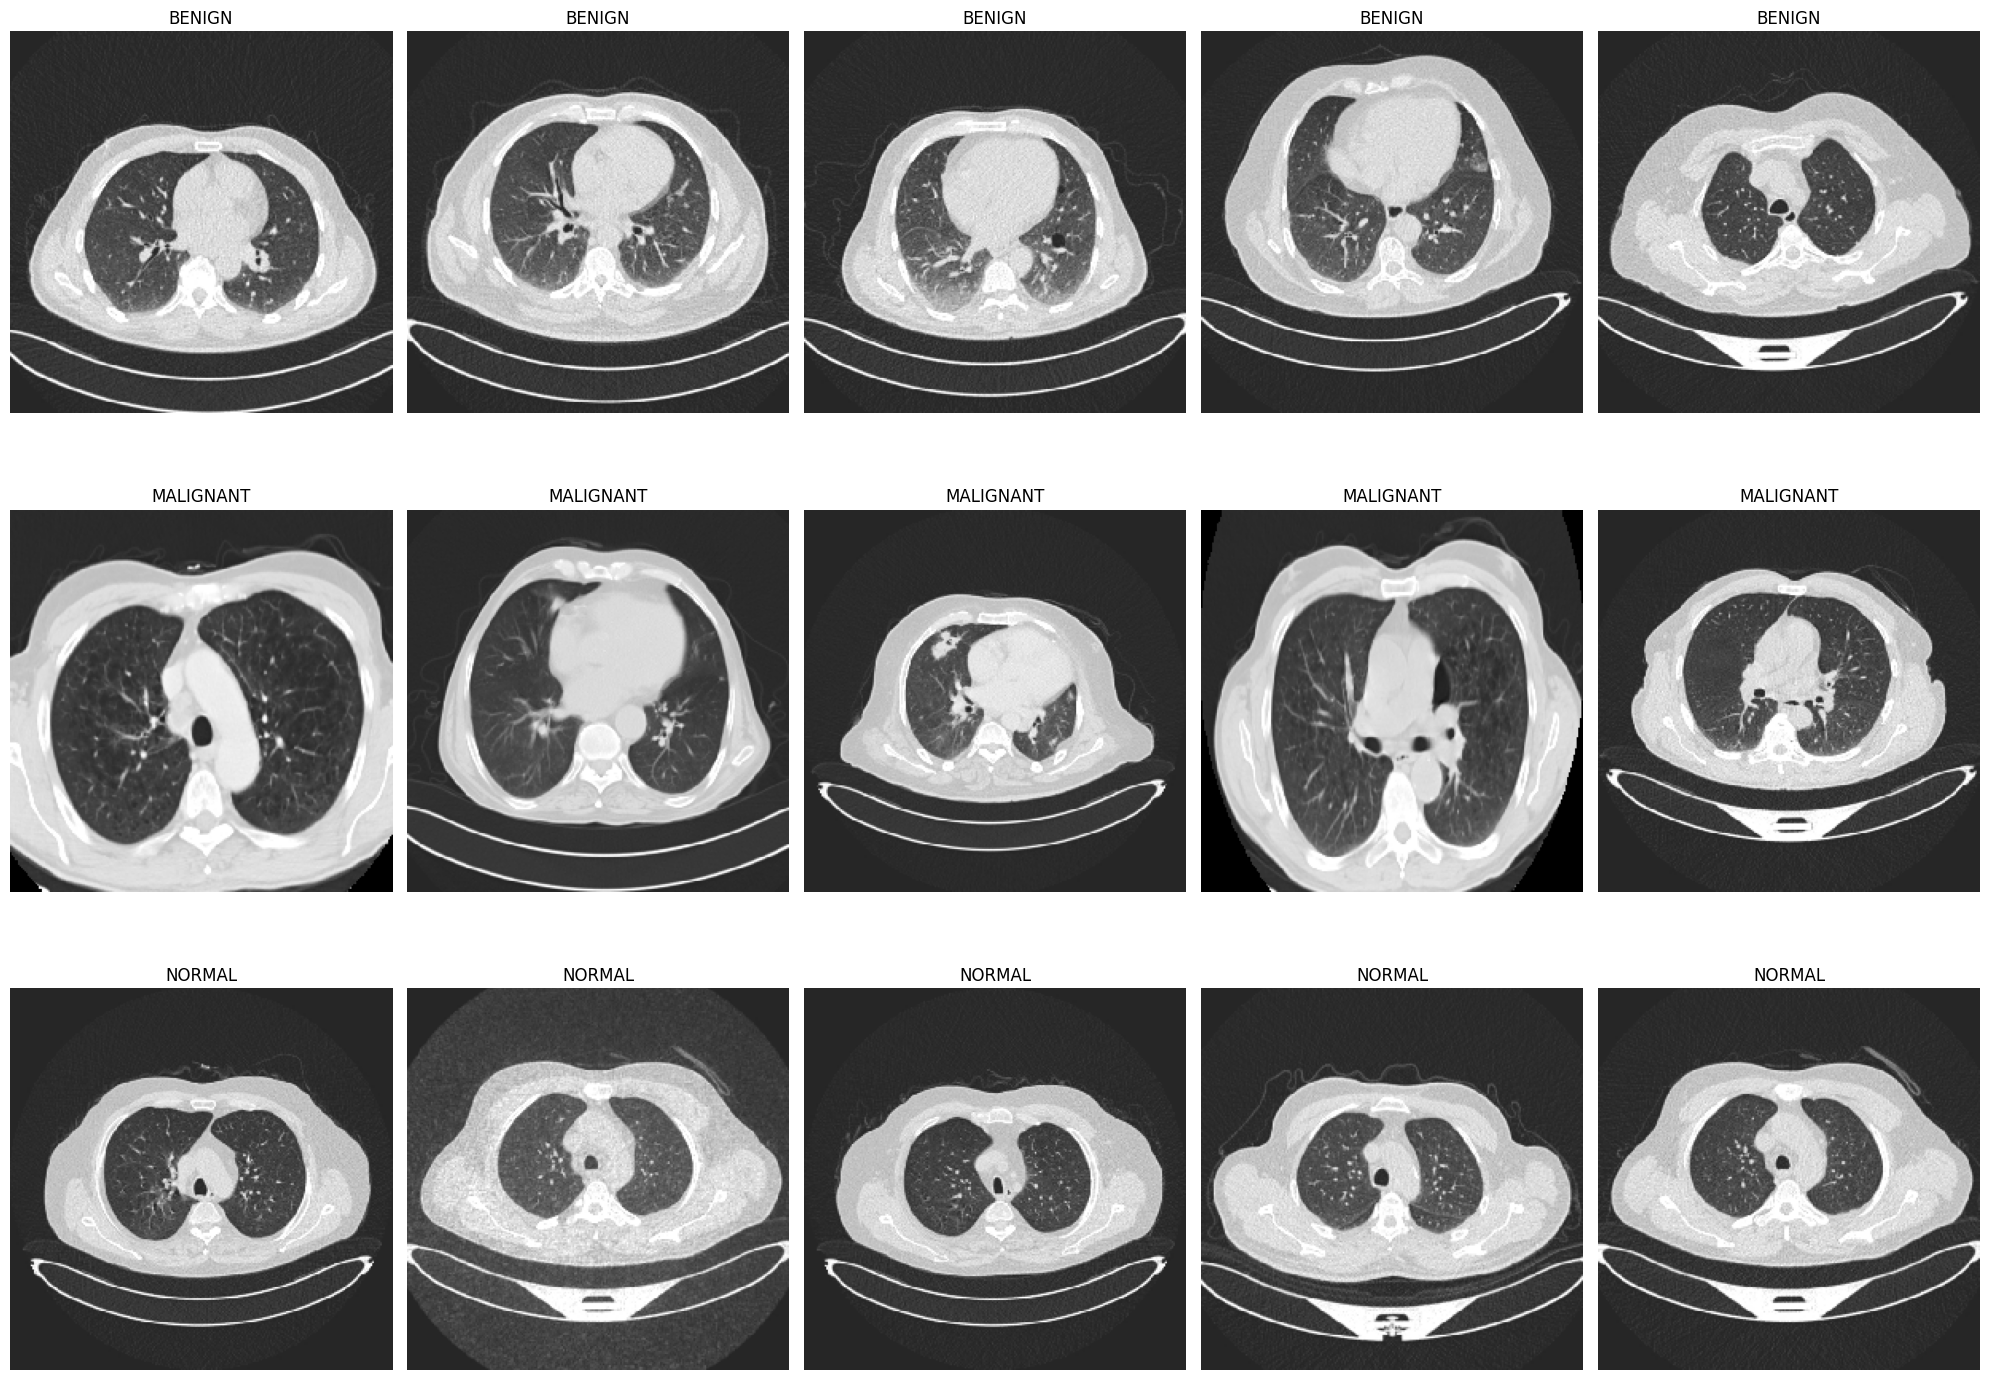

In [9]:
def display_random_images(class_names, train_path, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(20, 15))
    for row, cls in enumerate(class_names):
        path = os.path.join(train_path, cls)
        images = os.listdir(path)
        selected_images = random.sample(images, num_images)
        print(f"Class: {cls}")
        for col, img in enumerate(selected_images):
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(240, 240))
            if len(class_names) == 1:
                ax = axes[col]
            else:
                ax = axes[row, col]
            ax.imshow(image)
            ax.set_title(cls)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



class_names = ['BENIGN', 'MALIGNANT', 'NORMAL']
display_random_images(class_names, train_path)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


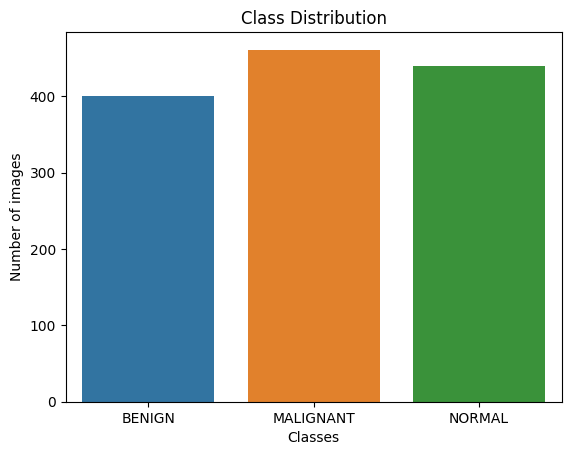

In [10]:

#  imbalance classes train set

def plot_class_distribution(train_path, class_names):
    class_counts = {}
    for cls in class_names:
        path = os.path.join(train_path, cls)
        count = len(os.listdir(path))
        class_counts[cls] = count

    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(train_path, class_names)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


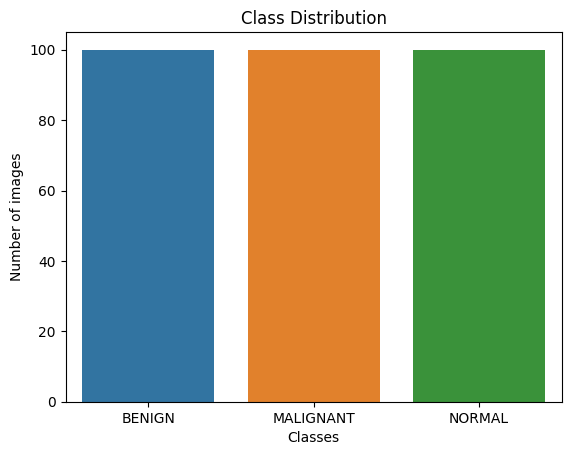

In [11]:
def plot_class_distribution(test_path_path, class_names):
    class_counts = {}
    for cls in class_names:
        path = os.path.join(test_path, cls)
        count = len(os.listdir(path))
        class_counts[cls] = count

    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(test_path, class_names)

In [12]:
# SNR (dB) = 10 × log ⁡ 10 ( signal power/ noise power )

# power of the signal (image pixel values)

# noise power(variance of the noise)

def calculate_snr(image, snr_db):
    # calculate signal power
    signal_power = np.mean(image ** 2)

    # calculate noise power
    noise_power = signal_power / (10 ** (snr_db / 10)) #convert SNR from dB to linear scale and calculate noise power
    return noise_power


In [13]:
def add_gaussian_noise(image, snr_db):
    row, col, ch = image.shape
    mean = 0
    noise_power = calculate_snr(image, snr_db)
    sigma = np.sqrt(noise_power)
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss
    return np.clip(noisy, 0, 255)


def add_salt_pepper_noise(image, snr_db):
    row, col, ch = image.shape
    s_vs_p = 0.5
    snr_linear = 10 ** (snr_db / 10) #converting it to a linear scale makes it easier in calculations
    corruption_ratio = 0.20 / (1 + snr_linear) #mapping the SNR to the amount of salt and pepper noise to add to the image
    # using a logarithmic scale for non-linear mapping
    # corruption_ratio = np.log10(1 + snr_linear**2) / np.log10(1 + max(snr_range)**2)  # max(snr_range) for normalization
    amount = corruption_ratio * image.size
    num_salt = np.ceil(amount * s_vs_p).astype(int)
    num_pepper = np.ceil(amount * (1 - s_vs_p)).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    image[coords] = 1
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    image[coords] = 0
    return image




In [14]:
# define SNR range between 30 - 40db
snr_range = np.linspace(30, 40, num=5)

# global variables to log noise details
global_noise_log = []

def custom_preprocessing_function(image):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    snr_db = random.choice(snr_range)
    noise_type = random.choice(['gaussian', 'salt_pepper'])

    # add noise to the image
    if noise_type == 'gaussian':
        image = add_gaussian_noise(image, snr_db)
    else:
        image = add_salt_pepper_noise(image, snr_db)

    # log noise details
    global_noise_log.append({'noise_type': noise_type, 'snr': snr_db})

    return image


In [15]:
global_epsilon_log = []

# define the FGSM attack function
def fgsm(image, labels, model, epsilon):
    # image is tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image, training=True)  # Use training=True if model behavior changes during training
        # compute the loss
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(labels, prediction))
    # calculate gradients
    gradient = tape.gradient(loss, image)
    # get the sign of the gradients
    signed_grad = tf.sign(gradient)
    # generate adversarial image
    adversarial_image = image + epsilon * signed_grad
    #images are within pixel value range
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)
  
    # Log epsilon details
    global_epsilon_log.append({'epsilon': epsilon})
    return adversarial_image

In [16]:
# adversarial training generator
def adversarial_training_generator(generator, model, epsilon):
    while True:
        x_batch, y_batch = next(generator)
        adversarial_x_batch = fgsm(x_batch, y_batch, model, epsilon=epsilon)
        yield adversarial_x_batch, y_batch

In [17]:
# Function to apply FGSM attack with varying epsilon levels
def apply_fgsm(model, image, label, epsilons):
    image = tf.convert_to_tensor(image)
    label = tf.convert_to_tensor(label)
    perturbed_images = [(epsilon, fgsm(image, label, model, epsilon)) for epsilon in epsilons]
    return perturbed_images

In [18]:
# function to display images
def plotImages(images_arr, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
# Plotting function
def plot_images(images_arr, titles_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, title, ax in zip(images_arr, titles_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Using K-Fold cross-validation, the data is split into training and validation sets multiple times. For each split, data generators are created to feed both noisy and clean images into the model for training and evaluation.

In [20]:
# get all image paths and their labels
def get_images_and_labels(base_dir):
    classes = ['BENIGN', 'MALIGNANT', 'NORMAL']
    images = []
    labels = []
    for cls in classes:
        cls_folder = os.path.join(base_dir, cls)
        cls_images = [os.path.join(cls_folder, filename) for filename in os.listdir(cls_folder)]
        images += cls_images
        labels += [cls] * len(cls_images)
    return images, labels

train_images, train_labels = get_images_and_labels(train_path)

In [21]:
# Preprocess image function
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [22]:
# create a DataFrame with the file paths and labels
df = pd.DataFrame({'filename': train_images, 'class': train_labels})

In [23]:
# define ImageDataGenerators
# is used for data augmentation and preprocessing of training a machine learning model with noisy images
train_datagen_noise = ImageDataGenerator(preprocessing_function=
        custom_preprocessing_function,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        # vertical_flip=True,
        shear_range=0.1,  #
        zoom_range=0.1,
        brightness_range=[0.8,1.2])


In [24]:
train_datagen_clean = ImageDataGenerator(preprocessing_function=
        preprocess_input,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        # vertical_flip=True,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8,1.2])

In [25]:
val_datagen_clean = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_noise = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)

In [26]:
# perform K-Fold Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [27]:
for fold, (train_idx, val_idx) in enumerate(kf.split(df)): # loop iterates over each fold//  get the indices of the training and validation sets
    print(f"Running fold {fold + 1}")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # create the generators using flow_from_dataframe
    train_generator_noise = train_datagen_noise.flow_from_dataframe(
        dataframe=train_df, #training data batches with noise
        directory=None,  # images are absolute paths
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    train_generator_clean = train_datagen_clean.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator_clean = val_datagen_clean.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator_noise = val_datagen_noise.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
    )

Running fold 1
Found 867 validated image filenames belonging to 3 classes.
Found 867 validated image filenames belonging to 3 classes.
Found 434 validated image filenames belonging to 3 classes.
Found 434 validated image filenames belonging to 3 classes.
Running fold 2
Found 867 validated image filenames belonging to 3 classes.
Found 867 validated image filenames belonging to 3 classes.
Found 434 validated image filenames belonging to 3 classes.
Found 434 validated image filenames belonging to 3 classes.
Running fold 3
Found 868 validated image filenames belonging to 3 classes.
Found 868 validated image filenames belonging to 3 classes.
Found 433 validated image filenames belonging to 3 classes.
Found 433 validated image filenames belonging to 3 classes.


train_generator_noise:


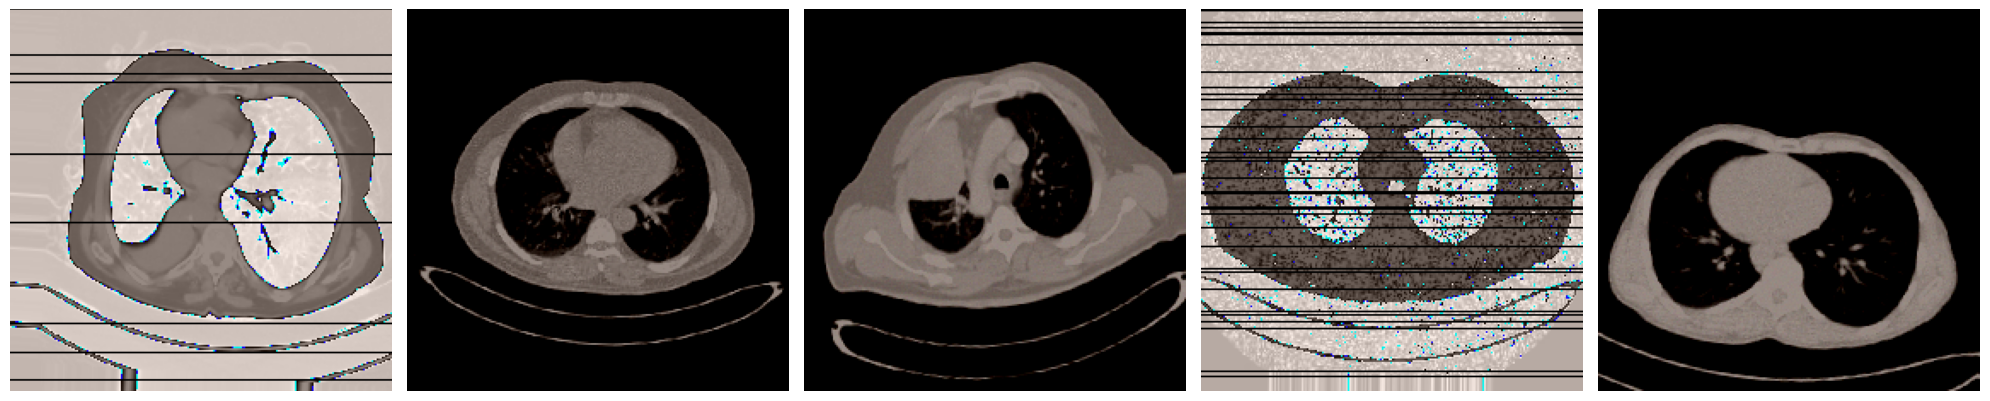

train_generator_clean:


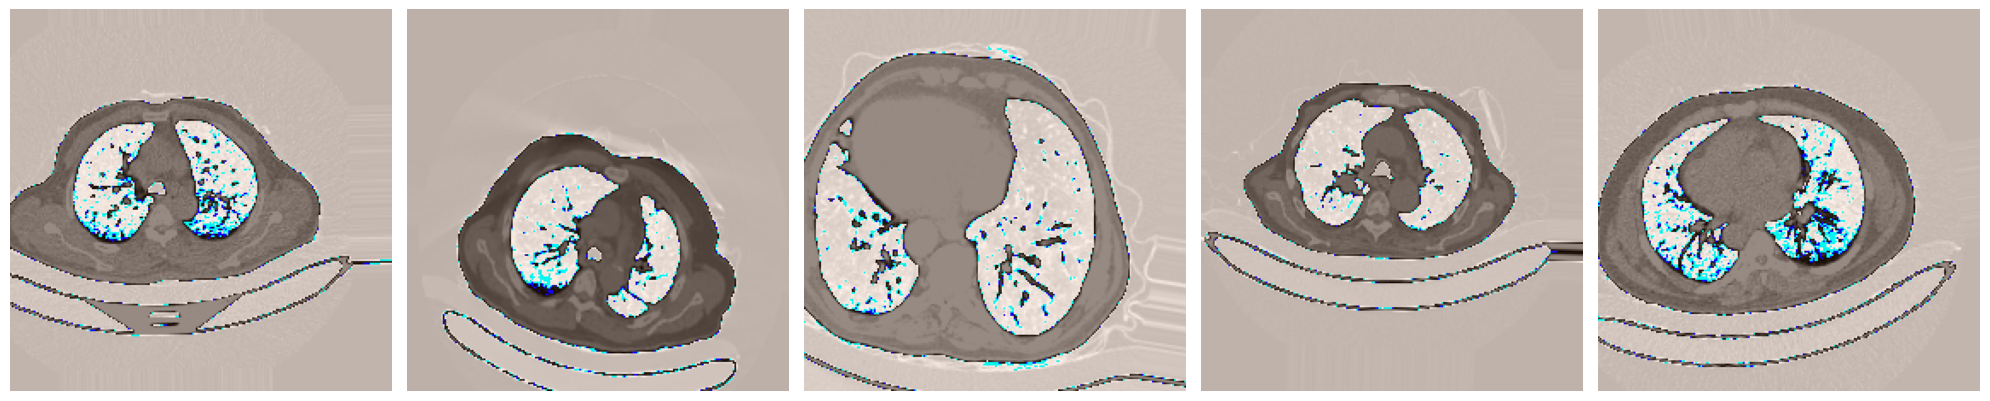

In [28]:
    # Retrieve and display images from the noisy data generator
    print("train_generator_noise:")
    images, labels = next(train_generator_noise)
    plotImages(images[:5])

    print("train_generator_clean:")
    # Retrieve and display images from the clean data generator
    images, labels = next(train_generator_clean)
    plotImages(images[:5])

In [29]:
    # add custom layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.4))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.4))(x)
    x = Dropout(0.5)(x)
    # x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    # x = Dropout(0.5)(x)  # Additional dropout layer
    # add a GaussianNoise layer to simulate and denoise from noise during training
    # x = GaussianNoise(0.1)(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes: benign, malignant, normal

    # create the final model
    model = Model(inputs=base_model.input, outputs=predictions)


#     model.summary()

In [30]:
#     plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [31]:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [32]:
    # class weights for the current training fold/ balancing training set
    train_classes = np.concatenate([train_generator_clean.classes, train_generator_noise.classes])

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_classes),
        y=train_classes)

    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [33]:
    # define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # monitor the validation loss
        patience=15, #number of epochs with no improvement the learning rate will be reduced
        verbose=1,    # number of epochs with no improvement after which training will be stopped
        restore_best_weights=True)  # restore model weights from the epoch with the best value of the monitored quantity

In [34]:
    # callback for learning rate scheduling //// avoiding overfitting and can be better convergence during training
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15,verbose=1, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)# min_lr: meaning there is no lower limit

In [35]:
    model_checkpoint_clean = ModelCheckpoint('clean_best_model.h5', save_best_only=True)  # Save the best model
    model_checkpoint_noise = ModelCheckpoint('noise_best_model.h5', save_best_only=True)  # Save the best model

In [36]:
    # visualize noise impact on the model validation accuracy over epochs.
    # visualize noise fluctuation during the training(noisy) plot and

    class NoiseScheduler(tf.keras.callbacks.Callback):
        def __init__(self, snr_range, noise_types, epsilons):
            super(NoiseScheduler, self).__init__()
            self.snr_range = snr_range
            self.noise_types = noise_types
            self.epsilons = epsilons
            self.snr_log = []
            self.noise_type_log = []  # log for noise types
            self.validation_accuracy = []
            self.epoch_log = []  # log for epoch numbers
            self.epsilon_log = []

        def on_epoch_begin(self, epoch, logs=None):
            # randomly select SNR and noise type for the current epoch
            snr_db = random.choice(self.snr_range)
            noise_type = random.choice(self.noise_types)
            self.snr_log.append(snr_db)
            epsilon = random.choice(self.epsilons)
            self.noise_type_log.append(noise_type)  # log the noise type
            self.epsilon_log.append(epsilon)

        def on_epoch_end(self, epoch, logs=None):
            val_acc = logs['val_accuracy'] if 'val_accuracy' in logs else None
            self.validation_accuracy.append(val_acc)
            self.epoch_log.append(epoch + 1)  # log the epoch number
            # log the SNR value and noise type
            print(f"Epoch {epoch+1} - SNR: {self.snr_log[-1]} dB, Noise Type: {self.noise_type_log[-1]}, Epsilon: {self.epsilon_log[-1]}")

        def on_train_end(self, logs=None):
            # plot SNR values, noise type, and validation accuracy over epochs
            epochs = list(range(1, len(self.validation_accuracy) + 1))
            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('SNR (dB)', color='tab:red')
            ax1.plot(epochs, self.snr_log, color='tab:red', marker='o', label='SNR (dB)')
            ax1.tick_params(axis='y', labelcolor='tab:red')

            # Add a second y-axis for noise type, categorical
            ax2 = ax1.twinx()
            noise_type_values = [self.noise_types.index(nt) for nt in self.noise_type_log]  # Convert noise types to numeric values for plotting
            ax2.set_ylabel('Noise Type', color='tab:green')
            ax2.scatter(epochs, noise_type_values, color='tab:green', label='Noise Type')
            ax2.tick_params(axis='y', labelcolor='tab:green')

            ax3 = ax1.twinx()
            ax3.spines['right'].set_position(('outward', 60))
            ax3.set_ylabel('Epsilon', color='tab:orange')
            ax3.plot(epochs, self.epsilon_log, color='tab:orange', marker='x', label='Epsilon')
            ax3.tick_params(axis='y', labelcolor='tab:orange')
            
            ax4 = ax1.twinx()
            ax4.spines['right'].set_position(('outward', 120))
            ax4.set_ylabel('Validation Accuracy', color='tab:blue')
            ax4.plot(epochs, self.validation_accuracy, color='tab:blue', marker='x', label='Validation Accuracy')
            ax4.tick_params(axis='y', labelcolor='tab:blue')


            fig.tight_layout()
            plt.title('SNR, Noise Type, Epsilon, and Validation Accuracy over Epochs')
            plt.show()






In [37]:
    batch_size = 32
    epsilons = np.linspace(0.0, 0.99, num=20)
    epsilons = [0.010, 0.100, 0.150]

    steps_per_epoch = train_generator_clean.n // train_generator_clean.batch_size
    validation_steps = val_generator_clean.n // val_generator_clean.batch_size


    # Train the model on the training dataset and validate on the validation dataset
    history_clean = model.fit(
        adversarial_training_generator(train_generator_clean, model, epsilons),
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator_clean,
        validation_steps=validation_steps,
        callbacks=[early_stopping,lr_scheduler, model_checkpoint_clean, tensorboard_callback],
        class_weight=class_weights_dict

        )

Epoch 1/10


I0000 00:00:1717446419.314170     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - ETA: 0s - loss: 761.1979 - accuracy: 0.5694 - precision: 0.6154 - recall: 0.4498 - auc: 0.7549

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 74s 1s/step - loss: 761.1979 - accuracy: 0.5694 - precision: 0.6154 - recall: 0.4498 - auc: 0.7549 - val_loss: 696.0677 - val_accuracy: 0.5577 - val_precision: 0.5822 - val_recall: 0.5024 - val_auc: 0.7799 - lr: 1.0000e-04
Epoch 2/10
27/27 [==============================] - 30s 1s/step - loss: 642.4403 - accuracy: 0.7361 - precision: 0.7704 - recall: 0.6759 - auc: 0.9071 - val_loss: 588.4703 - val_accuracy: 0.4519 - val_precision: 0.4787 - val_recall: 0.4327 - val_auc: 0.7221 - lr: 1.0000e-04
Epoch 3/10
27/27 [==============================] - 25s 978ms/step - loss: 540.3414 - accuracy: 0.8325 - precision: 0.8530 - recall: 0.8122 - auc: 0.9582 - val_loss: 495.9855 - val_accuracy: 0.5120 - val_precision: 0.5374 - val_recall: 0.4832 - val_auc: 0.7443 - lr: 1.0000e-04
Epoch 4/10
27/27 [==============================] - 26s 988ms/step - loss: 454.8584 - accuracy: 0.9115 - precision: 0.9247 - recall: 0.8959 - auc: 0.9836 - val_loss: 416.9766 - val_ac

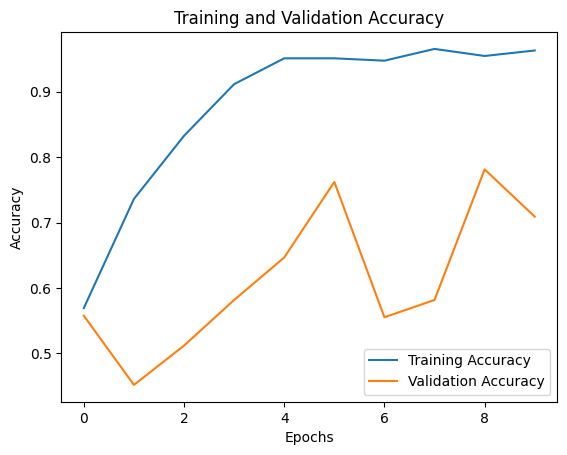

In [38]:
    # Plotting training and validation accuracies for clean
    plt.plot(history_clean.history['accuracy'], label='Training Accuracy')
    plt.plot(history_clean.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


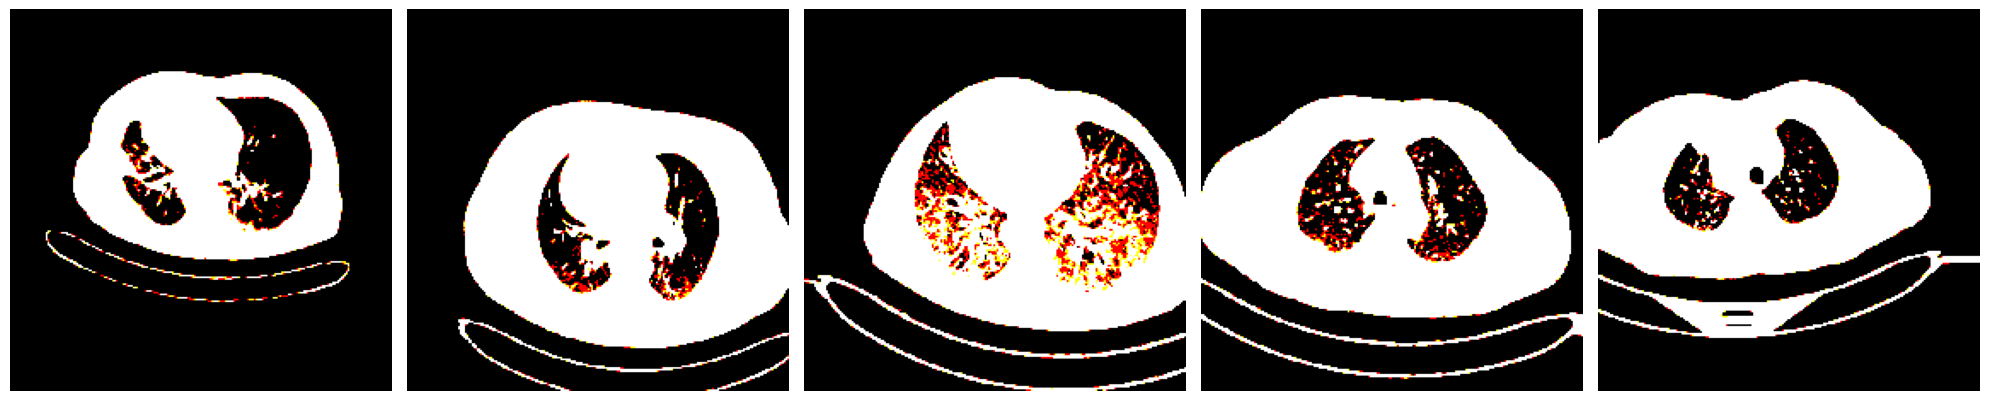

In [39]:
    def plotImages(images_arr, titles=None):
        fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
        axes = axes.flatten()
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)  # uint8 format
            ax.axis('off')
        if titles is not None:
            for ax, title in zip(axes, titles):
                ax.set_title(title)
        plt.tight_layout()
        plt.show()

    # generate a batch of adversarial images
    adversarial_images, _ = next(adversarial_training_generator(train_generator_clean, model, epsilon=0.9))

    # convert TensorFlow tensors to numpy arrays and rescale 

    adversarial_images_rescaled = np.array([img.numpy() for img in adversarial_images])

    # plot a subset of adversarial images
    plotImages(adversarial_images_rescaled[:5])

Epoch 1/10
27/27 [==============================] - 30s 1s/step - loss: 129.1701 - accuracy: 0.9019 - precision: 0.9176 - recall: 0.8792 - auc: 0.9737 - val_loss: 116.7152 - val_accuracy: 0.8245 - val_precision: 0.8494 - val_recall: 0.7861 - val_auc: 0.9530 - lr: 1.0000e-04
Epoch 2/10
27/27 [==============================] - 24s 921ms/step - loss: 106.4829 - accuracy: 0.9271 - precision: 0.9460 - recall: 0.9120 - auc: 0.9905 - val_loss: 96.5293 - val_accuracy: 0.8245 - val_precision: 0.8375 - val_recall: 0.8053 - val_auc: 0.9457 - lr: 1.0000e-04
Epoch 3/10
27/27 [==============================] - 24s 920ms/step - loss: 87.6395 - accuracy: 0.9342 - precision: 0.9400 - recall: 0.9187 - auc: 0.9886 - val_loss: 79.6205 - val_accuracy: 0.8269 - val_precision: 0.8396 - val_recall: 0.8053 - val_auc: 0.9532 - lr: 1.0000e-04
Epoch 4/10
27/27 [==============================] - 25s 956ms/step - loss: 72.1770 - accuracy: 0.9569 - precision: 0.9659 - recall: 0.9486 - auc: 0.9946 - val_loss: 65.7652

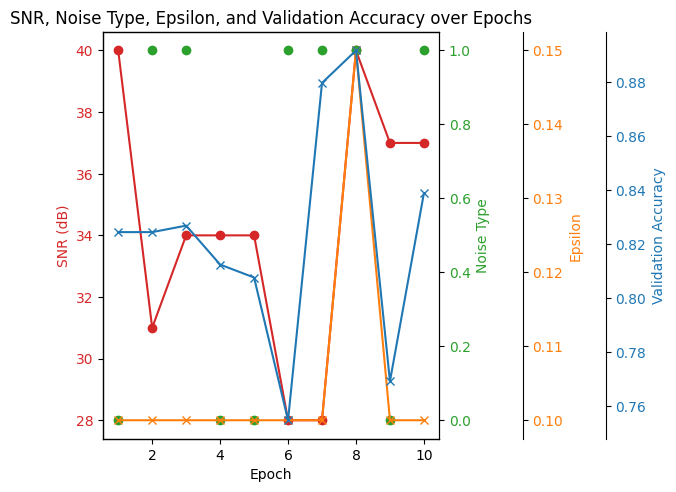

In [40]:

    # Define SNR range and noise types for the NoiseScheduler
    snr_range = np.linspace(28, 40, num=5)
    noise_types = ['gaussian', 'salt_pepper']
    
    epsilons = [0.10, 0.10, 0.150]

    # NoiseScheduler with the SNR range and noise types
    noise_scheduler = NoiseScheduler(snr_range, noise_types, epsilons)
    batch_size = 32


    steps_per_epoch = train_generator_noise.n // train_generator_noise.batch_size
    validation_steps = val_generator_noise.n // val_generator_noise.batch_size

    # calculated steps in model.fit()
    history_noisy = model.fit(
        adversarial_training_generator(train_generator_noise, model, epsilons),
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=val_generator_noise,
        validation_steps=validation_steps,
        callbacks=[noise_scheduler, early_stopping, lr_scheduler, model_checkpoint_noise],
        class_weight=class_weights_dict
    )

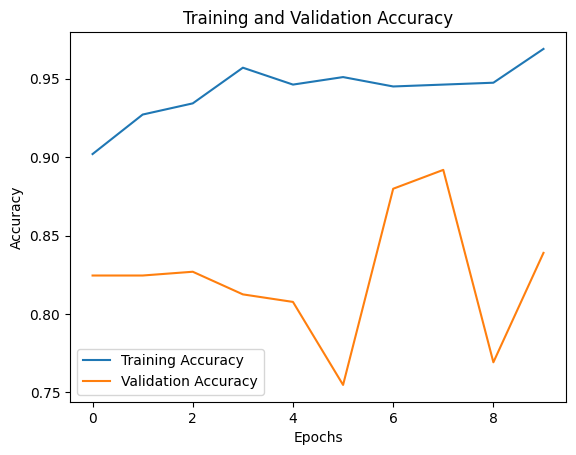

In [41]:
    # Plotting training and validation accuracies for noise
    plt.plot(history_noisy.history['accuracy'], label='Training Accuracy')
    plt.plot(history_noisy.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [42]:
    results_df = pd.DataFrame({
        'Epoch': noise_scheduler.epoch_log,
        'SNR': noise_scheduler.snr_log,
        'Noise_Type': noise_scheduler.noise_type_log,
        'Epsilon': noise_scheduler.epsilon_log,
        'Validation_Accuracy': noise_scheduler.validation_accuracy
        
    })

    # Display the DataFrame
    print(results_df)

   Epoch   SNR   Noise_Type  Epsilon  Validation_Accuracy
0      1  40.0     gaussian     0.10             0.824519
1      2  31.0  salt_pepper     0.10             0.824519
2      3  34.0  salt_pepper     0.10             0.826923
3      4  34.0     gaussian     0.10             0.812500
4      5  34.0     gaussian     0.10             0.807692
5      6  28.0  salt_pepper     0.10             0.754808
6      7  28.0  salt_pepper     0.10             0.879808
7      8  40.0  salt_pepper     0.15             0.891827
8      9  37.0     gaussian     0.10             0.769231
9     10  37.0  salt_pepper     0.10             0.838942


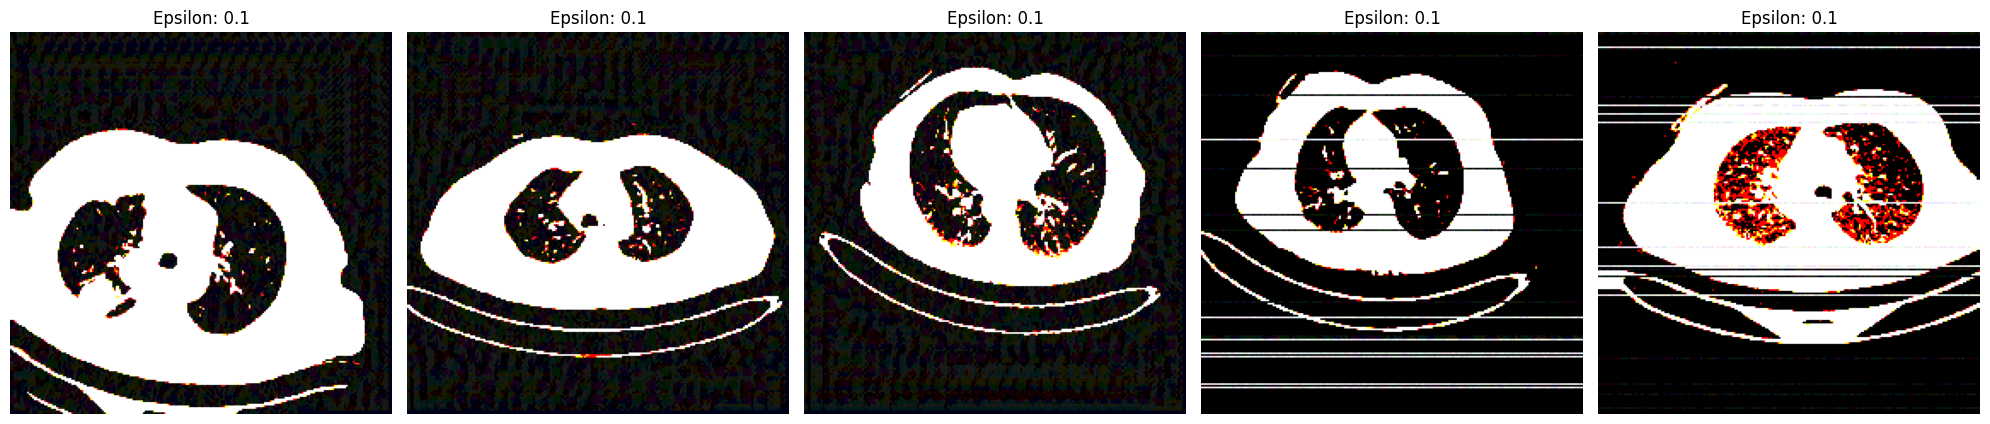

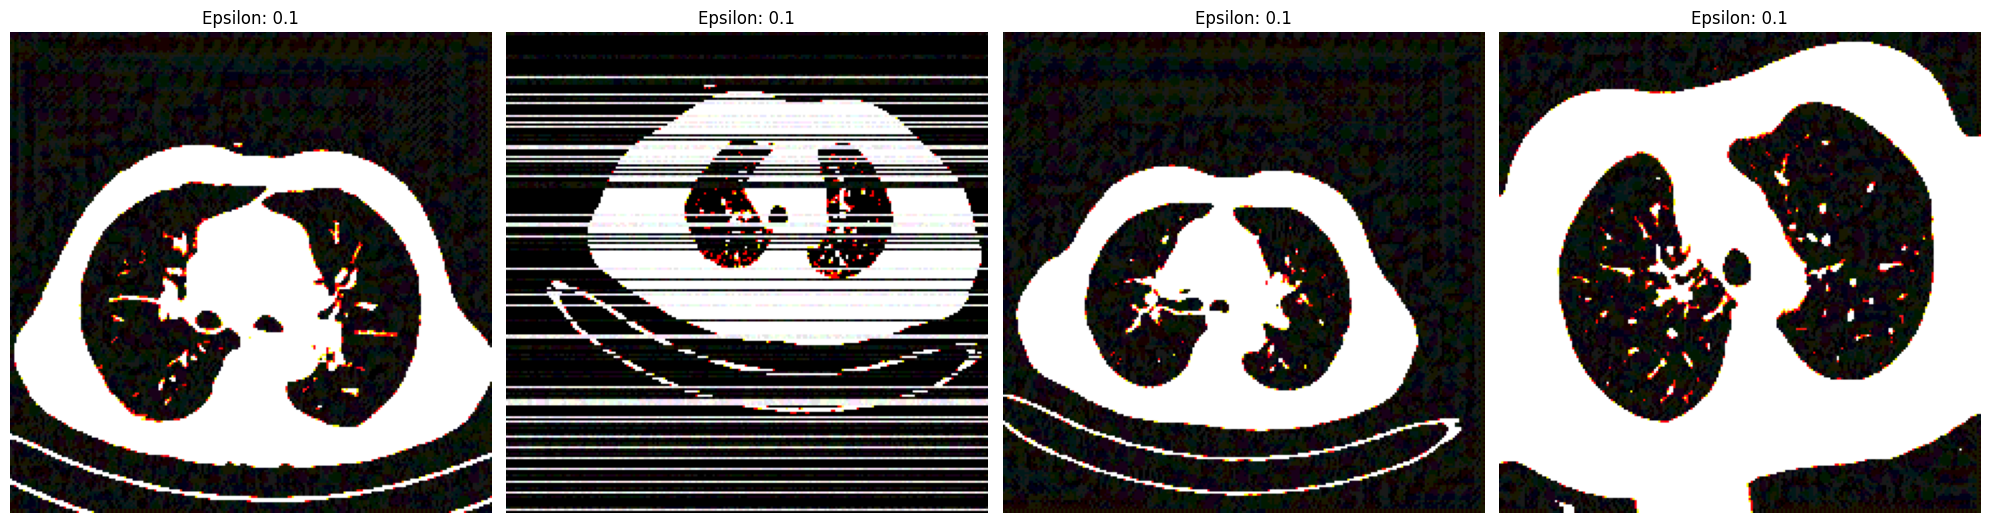

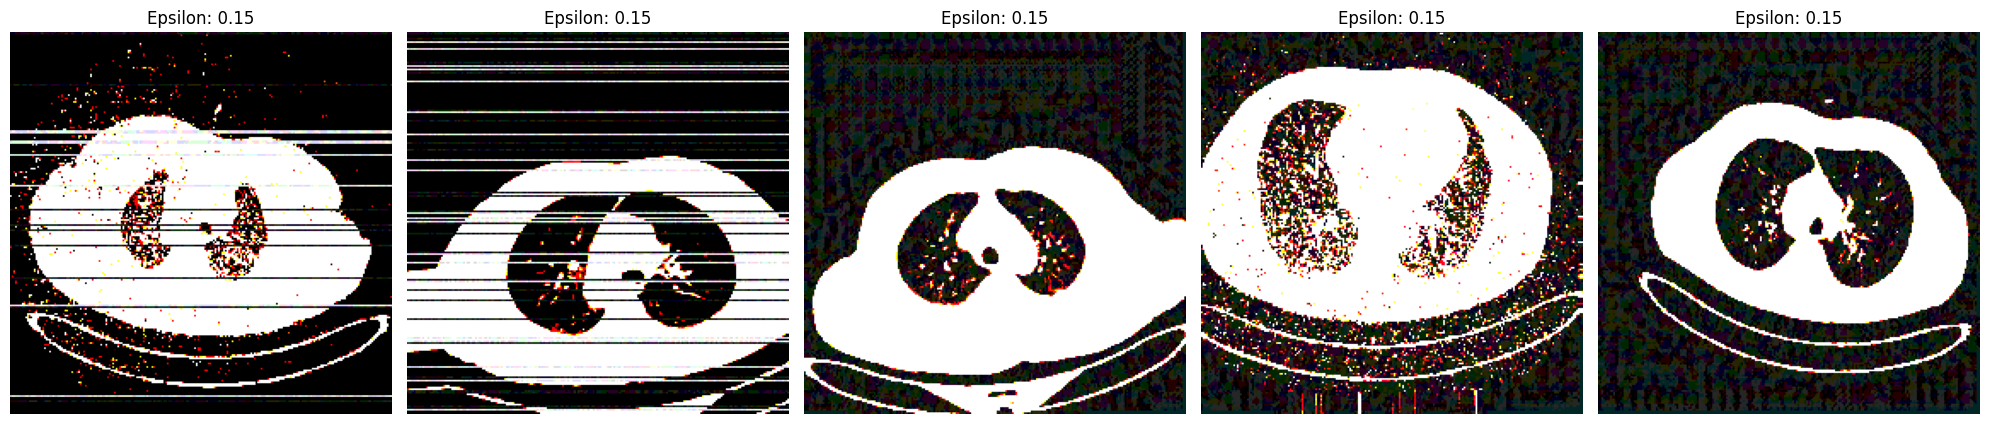

In [43]:
    # Function to plot images with titles
    def plotImages(images_arr, titles=None):
        fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
        axes = axes.flatten()
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)  # correct uint8 format
            ax.axis('off')
        if titles is not None:
            for ax, title in zip(axes, titles):
                ax.set_title(title)
        plt.tight_layout()
        plt.show()

    # Define the range of epsilon values
    epsilons = [0.10, 0.10, 0.150]

    # Generate and plot adversarial images for different levels of epsilon
    for epsilon in epsilons:
        # Generate a batch of adversarial images
        adversarial_images, _ = next(adversarial_training_generator(train_generator_noise, model, epsilon=epsilon))

        # Convert TensorFlow tensors to numpy arrays and rescale
        adversarial_images_rescaled = np.array([img.numpy() for img in adversarial_images])

        # Plot a subset of adversarial images
        plotImages(adversarial_images_rescaled[:5], titles=[f'Epsilon: {epsilon}']*5)


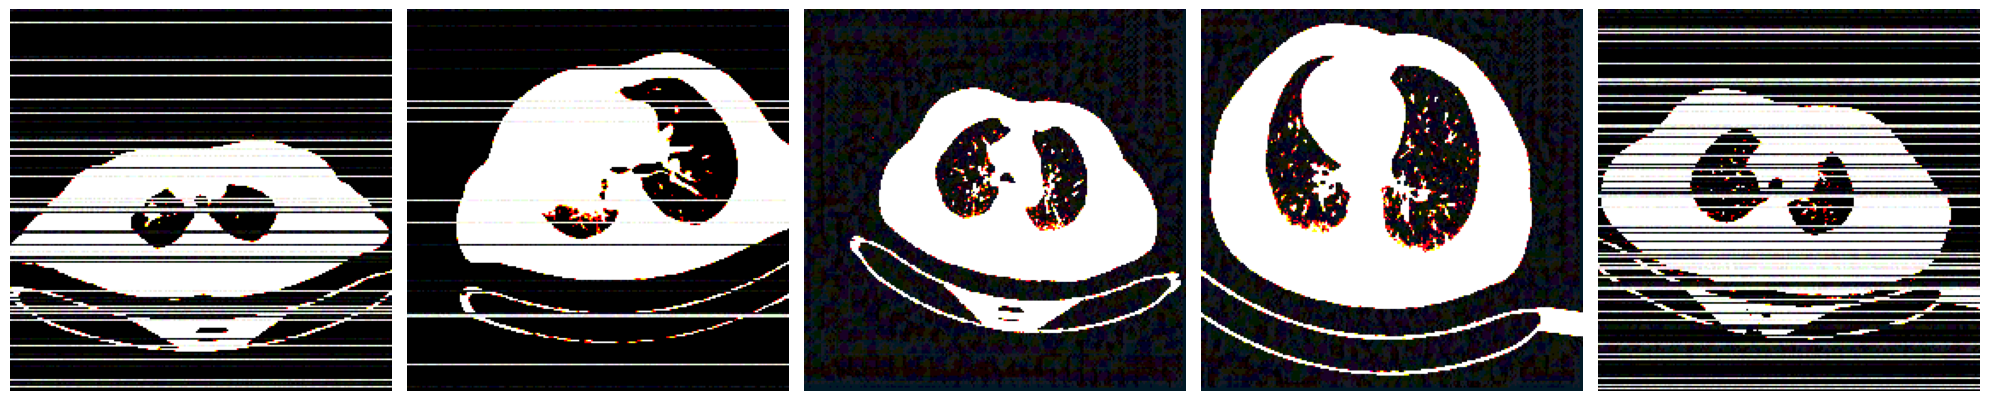

In [44]:
    def plotImages(images_arr, titles=None):
        fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
        axes = axes.flatten()
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)  # correct uint8 format
            ax.axis('off')
        if titles is not None:
            for ax, title in zip(axes, titles):
                ax.set_title(title)
        plt.tight_layout()
        plt.show()

    # generate a batch of adversarial images
    adversarial_images, _ = next(adversarial_training_generator(train_generator_noise, model, epsilons))

    # convert TensorFlow tensors to numpy arrays and rescale 

    adversarial_images_rescaled = np.array([img.numpy() for img in adversarial_images])

    # plot a subset of adversarial images
    plotImages(adversarial_images_rescaled[:5])

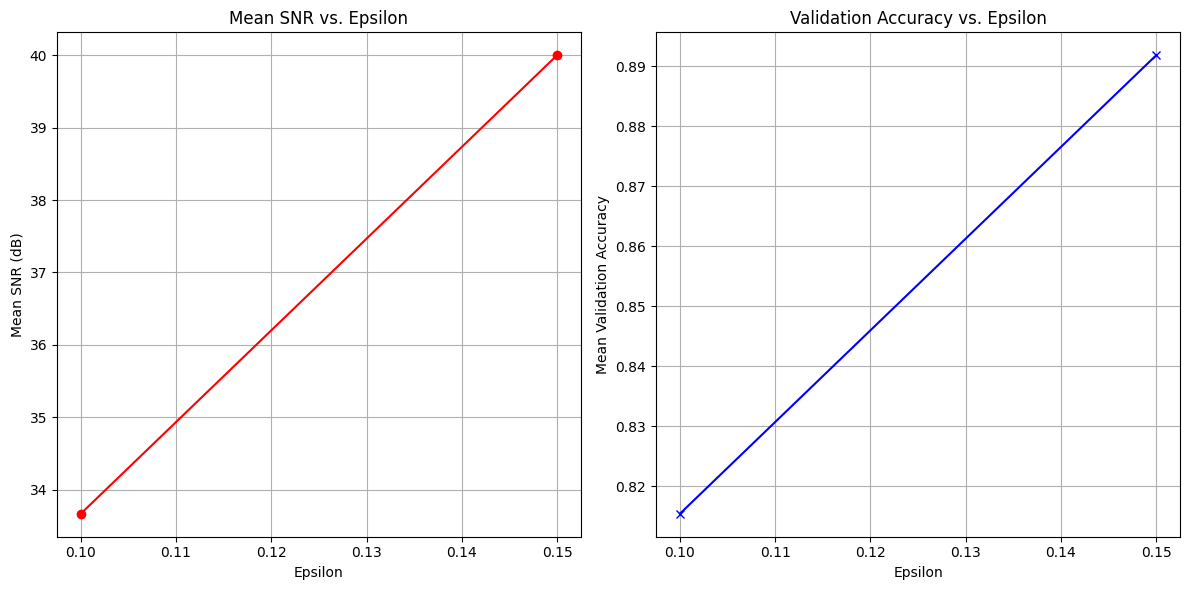

In [45]:
    import matplotlib.pyplot as plt

    # Assuming results_df contains columns: 'Epsilon', 'SNR', and 'Validation_Accuracy'

    # Group the DataFrame by 'Epsilon' and calculate mean SNR and Validation Accuracy for each epsilon
    grouped_df = results_df.groupby('Epsilon').agg({'SNR': 'mean', 'Validation_Accuracy': 'mean'}).reset_index()

    # Plotting the impact of epsilon of adversarial attack with SNR levels
    plt.figure(figsize=(12, 6))

    # Plot SNR levels for each epsilon
    plt.subplot(1, 2, 1)
    plt.plot(grouped_df['Epsilon'], grouped_df['SNR'], marker='o', linestyle='-', color='r')
    plt.xlabel('Epsilon')
    plt.ylabel('Mean SNR (dB)')
    plt.title('Mean SNR vs. Epsilon')
    plt.grid(True)

    # Plot Validation Accuracy for each epsilon
    plt.subplot(1, 2, 2)
    plt.plot(grouped_df['Epsilon'], grouped_df['Validation_Accuracy'], marker='x', linestyle='-', color='b')
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Validation Accuracy')
    plt.title('Validation Accuracy vs. Epsilon')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [46]:
    # clean dataset training
    final_accuracy_clean = history_clean.history['accuracy'][-1]
    final_val_accuracy_clean = history_clean.history['val_accuracy'][-1]

    print(f"Final Training Accuracy (Clean): {final_accuracy_clean*100:.2f}%")
    print(f"Final Validation Accuracy (Clean): {final_val_accuracy_clean*100:.2f}%")

    # noisy dataset training
    final_accuracy_noisy = history_noisy.history['accuracy'][-1]
    final_val_accuracy_noisy = history_noisy.history['val_accuracy'][-1]

    print(f"Final Training Accuracy (Noisy): {final_accuracy_noisy*100:.2f}%")
    print(f"Final Validation Accuracy (Noisy): {final_val_accuracy_noisy*100:.2f}%")

Final Training Accuracy (Clean): 96.29%
Final Validation Accuracy (Clean): 70.91%
Final Training Accuracy (Noisy): 96.89%
Final Validation Accuracy (Noisy): 83.89%


In [47]:
# create test data generators

def create_test_generators(batch_size=32):

    clean_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

    noise_test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing_function)

    clean_test_generator = clean_test_datagen.flow_from_directory(
        test_path,  # Path to clean test data
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # for evaluation
    )

    noise_test_generator = noise_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # retrieve and display images from the noisy data generator
    print("clean_test_generator:")
    images, labels = next(clean_test_generator)
    plotImages(images[:5])

    print("Noise_test_generator:")
    # retrieve and display images from the clean data generator
    images, labels = next(noise_test_generator)
    plotImages(images[:5])

    return clean_test_generator, noise_test_generator

In [48]:
class_names = ['benign', 'malignant', 'normal']


def evaluate_model_with_arrays(model, images, true_labels, class_names):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    print('Accuracy:', accuracy_score(true_classes, predicted_classes))

In [49]:
# Evaluate the model
model.load_weights('clean_best_model.h5')  # Load the best model saved by ModelCheckpoint

Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
clean_test_generator:


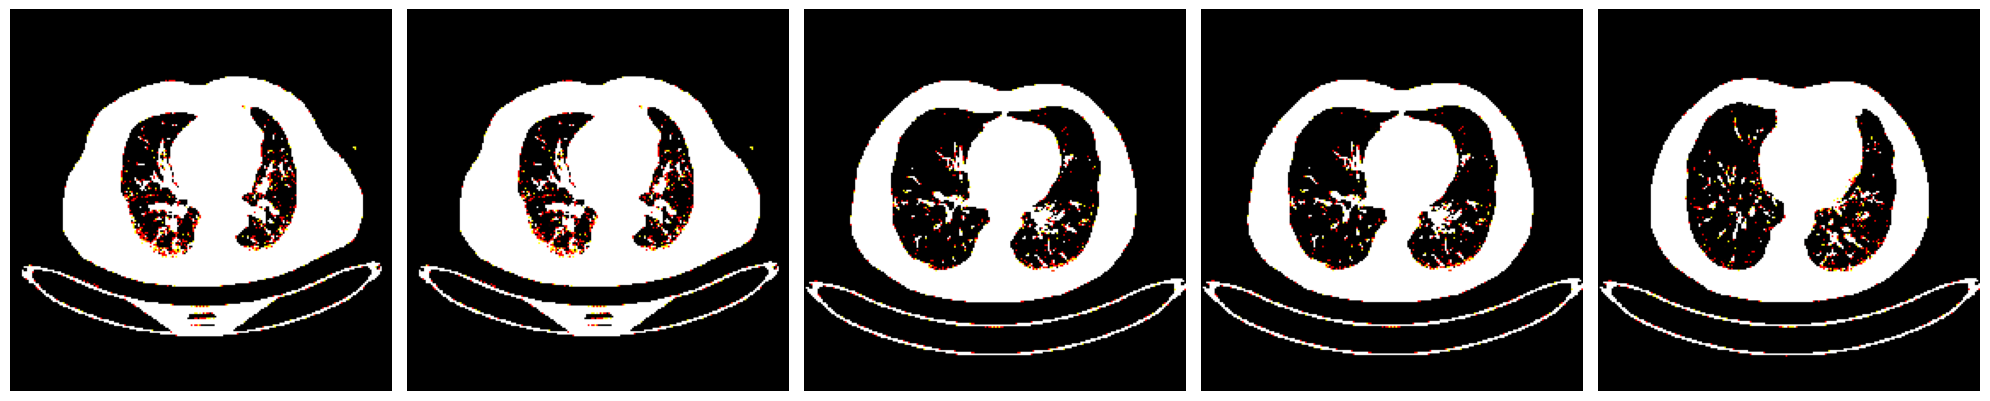

Noise_test_generator:


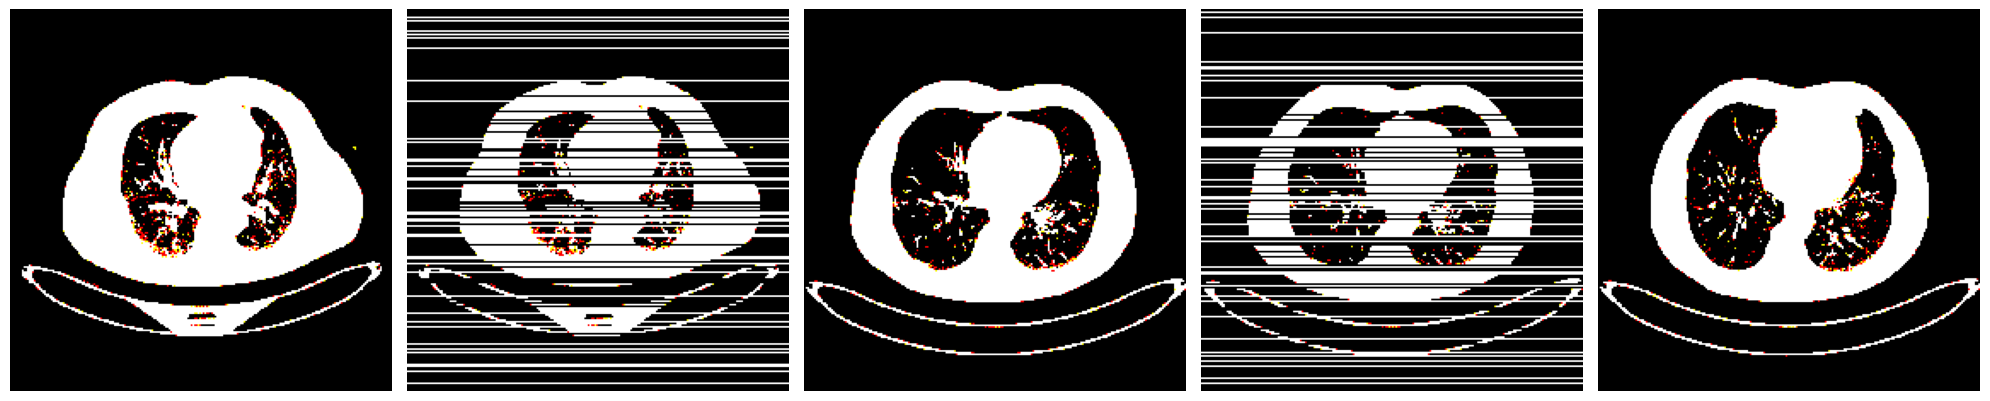

In [50]:
# import pandas as pd

# reset the global noise log before evaluation
global_noise_log = []

clean_test_gen, noise_test_gen = create_test_generators(batch_size=32)




In [51]:
global_epsilon_log = []

# function to generate adversarial for the entire test dataset
def generate_adversarial_test_data(generator, model, epsilon):
    adversarial_images = []
    adversarial_labels = []
    # iterate over the test data generator
    for images, labels in generator:
        # convert labels to the correct format for categorical crossentropy
        labels_one_hot = tf.one_hot(labels.argmax(axis=1), depth=labels.shape[1])
        # generate adversarial examples
        adversarial_batch = fgsm(images, labels_one_hot, model, epsilon=epsilon)
        adversarial_images.append(adversarial_batch)
        adversarial_labels.append(labels)
        if len(adversarial_images) >= len(generator):
            break
    # concatenate all batches
    adversarial_images = np.vstack(adversarial_images)
    adversarial_labels = np.vstack(adversarial_labels)
    return adversarial_images, adversarial_labels

In [52]:
# generate adversarial test clean data
adversarial_images_clean, adversarial_labels_clean = generate_adversarial_test_data(clean_test_gen, model, epsilon)

In [53]:
# evaluate on clean test clean data

clean_test_loss, clean_test_accuracy, clean_test_precision, clean_test_recall, clean_test_auc = model.evaluate(adversarial_images_clean, adversarial_labels_clean, verbose=1)
print(f"Clean Test Accuracy: {clean_test_accuracy * 100:.2f}%%, Precision: {clean_test_precision}, Recall: {clean_test_recall}, AUC: {clean_test_auc}")

10/10 [==============================] - 1s 94ms/step - loss: 141.7283 - accuracy: 0.6200 - precision: 0.6182 - recall: 0.6100 - auc: 0.8320
Clean Test Accuracy: 62.00%%, Precision: 0.6182432174682617, Recall: 0.6100000143051147, AUC: 0.8319694399833679


In [54]:

# evaluate on clean test data with adversarial examples
print("Evaluation on Clean Test Data with Adversarial Examples:")
evaluate_model_with_arrays(model, adversarial_images_clean, adversarial_labels_clean, class_names)

Evaluation on Clean Test Data with Adversarial Examples:
10/10 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

      benign       0.45      0.65      0.53       100
   malignant       0.99      0.91      0.95       100
      normal       0.46      0.30      0.36       100

    accuracy                           0.62       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.64      0.62      0.62       300

Accuracy: 0.62


In [55]:
model.load_weights('noise_best_model.h5')  # load the best model saved by ModelCheckpoint

In [56]:
# generate adversarial test noise data
adversarial_images, adversarial_labels = generate_adversarial_test_data(noise_test_gen, model, epsilon)

In [57]:
# function to evaluate model on adversarial test data
def evaluate_on_adversarial_data(model, images, labels):
    noise_test_loss, noise_test_accuracy, noise_test_precision, noise_test_recall, noise_test_auc = model.evaluate(images, labels, verbose=1)
    # Create a DataFrame to store metrics with noise details
    # Create a DataFrame to store metrics with noise and epsilon details
    metrics_df_noise = pd.DataFrame(global_noise_log)
    metrics_df_epsilon = pd.DataFrame(global_epsilon_log)
    
    # Combine noise and epsilon DataFrames
    metrics_df = pd.concat([metrics_df_noise, metrics_df_epsilon], axis=1)
    
    
    metrics_df['Accuracy'] = noise_test_accuracy
    metrics_df['Precision'] = noise_test_precision
    metrics_df['Recall'] = noise_test_recall
    metrics_df['AUC'] = noise_test_auc

    
    # Display the DataFrame
    print(metrics_df)

# evaluate the model on adversarial test data
evaluate_on_adversarial_data(model, adversarial_images, adversarial_labels)

10/10 [==============================] - 1s 62ms/step - loss: 20.8246 - accuracy: 0.5900 - precision: 0.5926 - recall: 0.5867 - auc: 0.7504
      noise_type   snr  epsilon  Accuracy  Precision    Recall       AUC
0       gaussian  40.0     0.15      0.59   0.592593  0.586667  0.750383
1    salt_pepper  28.0     0.15      0.59   0.592593  0.586667  0.750383
2       gaussian  40.0     0.15      0.59   0.592593  0.586667  0.750383
3    salt_pepper  28.0     0.15      0.59   0.592593  0.586667  0.750383
4       gaussian  40.0     0.15      0.59   0.592593  0.586667  0.750383
..           ...   ...      ...       ...        ...       ...       ...
327     gaussian  37.0      NaN      0.59   0.592593  0.586667  0.750383
328     gaussian  37.0      NaN      0.59   0.592593  0.586667  0.750383
329     gaussian  31.0      NaN      0.59   0.592593  0.586667  0.750383
330     gaussian  37.0      NaN      0.59   0.592593  0.586667  0.750383
331     gaussian  37.0      NaN      0.59   0.592593  0.5

In [58]:
# evaluate on clean test data
print("Evaluation noise Test Data:")
evaluate_model_with_arrays(model, adversarial_images, adversarial_labels, class_names)

Evaluation noise Test Data:
10/10 [==============================] - 1s 55ms/step
              precision    recall  f1-score   support

      benign       0.41      0.50      0.45       100
   malignant       0.99      0.87      0.93       100
      normal       0.44      0.40      0.42       100

    accuracy                           0.59       300
   macro avg       0.61      0.59      0.60       300
weighted avg       0.61      0.59      0.60       300

Accuracy: 0.59


 Precision: measures the ratio of correctly predicted positive observations to the total predicted positives.

 Recal: actual positive cases were correctly identified by the model.

 AUC: good ability of the model to distinguish between classes.

References:


https://medium.com/@dnyaneshwalwadkar/fix-training-accuracy-fluctuation-over-fitting-problem-in-deep-learning-algorithm-859573090809

\

https://github.com/MedMachine00/Deep-learning-based-coronary-artery-segmentation/tree/main

\

https://github.com/Paperspace/DataAugmentationForObjectDetection/blob/master/quick-start.ipynb


\


https://www.researchgate.net/publication/352806683_Image_De-Noising_with_Machine_Learning_A_Review#:~:text=This%20paper%20explores%20the%20numerous,networks%20and%20generative%20adversarial%20networks

\
https://arxiv.org/pdf/1609.03683.pdf

\

https://keras.io/api/

\

https://www.researchgate.net/publication/371699794_Deep_learning_techniques_on_3D-MRI_lung_images_for_detection_and_segmentation_of_COVID-19_virus

\
https://link.springer.com/article/10.1007/s10462-023-10453-z#Sec21

\
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7085309/


\
https://mrimaster.com/snr/

\

https://radiopaedia.org/articles/signal-to-noise-ratio-mri?lang=gb

\
https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a?ref=blog.roboflow.com

\
Litjens, Geert, et al. "A survey on deep learning in medical image analysis." Medical image analysis 42 (2017)


Ker, Justin, et al. "Deep learning applications in medical image analysis." IEEE Access 6 (2018).

https://debuggercafe.com/adding-noise-to-image-data-for-deep-learning-data-augmentation/

signal-to-noise ratio (SNR) in dB. SNR is calculated using the formula:

SNR (dB)
=
10
×
log
⁡
10
(
signal power/
noise power
)

power of the signal (image pixel values)

noise power(variance of the noise)

Next steps:\
1- should tune the model to get better accuracy on test set

2- try diferent models like DenseNet, more suitable for this task because advantages of feature reuse.

3- try advanced data augmentation techniques like rotation, skewing, or elastic deformations.

4- try automated hyperparameter tuning methods like grid search or Bayesian optimization can systematically find the best parameters.

5- try advanced noise models like motion blur, low-dose artifacts and low-light conditions

6- try ensemble methods, combining the outputs of multiple models can improve overall performance. averaging the predictions.

7- try hybrid approach, traditional machine learning classifiers (like SVM or Random Forest) for the final classification task.

8- try hyperparameter tuning, use tools like Keras Tuner or Hyperopt for automated hyperparameter optimization.